# Comparison of equations of state for model fluids

In this notebook, we take a look at various model fluid equations of state and compare them.
These EoS are:

- The PeTS equation of state (from `feos.pets`),
- the uv-theory equation of state (from `feos.uvtheory`), 
- the uv-B3-theory equation of state (from `feos.uvtheory` using `Perturbation.`), and
- the Thol equation of state (implemented in this notebook as Python class).

The PeTS equation of state is for a Lennard-Jones fluid with cut off distance of $r_c = 2.5 \sigma$ and a potential shift while the uv-theory and Thol equation of state model the full Lennard-Jones potential. Note that the uv-theory was developed to model Mie potentials and not primarily adjusted to the Lennard-Jones fluid. Thus, we don't expect similar results when comparing uv-theory and Thol to PeTS.

In [2]:
import numpy as np
from feos.si import *
from feos.uvtheory import UVTheoryParameters, Perturbation
from feos.pets import PetsParameters
from feos.eos import State, PhaseEquilibrium, PhaseDiagram, EquationOfState, Contributions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

sns.set_context('talk')
sns.set_palette("hls", 8)
sns.set_style('ticks')
colors = sns.palettes.color_palette('Dark2', 8)

## Implement the Thol equation of state as Python class

In [3]:
# Parameters for Thol EoS:
A = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0,
              2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0])
N = np.array([0.005208073, 2.186252000, -2.161016000, 1.452700000, -2.041792000, 0.186952860, -0.090988445, 
              -0.497456100, 0.109014310, -0.800559220, -0.568839000, -0.620862500, -1.466717700, 1.891469000, 
              -0.138370100, -0.386964500, 0.126570200, 0.605781000, 1.179189000, -0.477326790, -9.921857500, -0.574793200, 0.003772923])
T = np.array([1.000, 0.320, 0.505, 0.672, 0.843, 0.898, 1.294, 2.590, 1.786, 2.770, 1.786,
              1.205, 2.830, 2.548, 4.650, 1.385, 1.460, 1.351, 0.660, 1.496, 1.830, 1.616, 4.970])
D = np.array([4.0, 1.0, 1.0, 2.0, 2.0, 3.0, 5.0, 2.0, 2.0, 3.0, 1.0,
              1.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 1.0])
L = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0,
              1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
ETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.067, 1.522,
                8.82, 1.722, 0.679, 1.883, 3.925, 2.461, 28.2, 0.753, 0.82])
BETA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.625,
                 0.638, 3.91, 0.156, 0.157, 0.153, 1.16, 1.73, 383, 0.112, 0.119])
GAMMA = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.71,
                  0.86, 1.94, 1.48, 1.49, 1.945, 3.02, 1.11, 1.17, 1.33, 0.24])
EPSILON = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.2053,
                    0.409, 0.6, 1.203, 1.829, 1.397, 1.39, 0.539, 0.934, 2.369, 2.43])

class Thol:
    def __init__(self):
        self.sigma = 3.7039 * ANGSTROM
        self.eps_k = 150.03 * KELVIN
        self.tc = 1.32 * self.eps_k / KELVIN
        self.rhoc = 0.31 / self.sigma**3 * ANGSTROM**3
        
    def components(self): 
        return 1
    
    def subset(self, components):
        return self
        
    def molar_weight(self):
        return np.array([1.0])
    
    def max_density(self, moles):
        return 0.04
    
    def helmholtz_energy(self, state):
        """
        state (StateHD):
            temperature in Kelvin als Float, Dual oder HD oder HD3, HDD, HDD3,
            partial_density in # / Angstrom^3
            volume in Angstrom^3
            moles in mol
        """
        tau = self.tc / state.temperature
        delta = np.sum(state.partial_density) / self.rhoc
        a = 0.0
        
        for i in range(6):
            a = a + N[i] * delta**D[i] * tau**T[i]
        for i in range(6, 12):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(-1.0 * delta**L[i])
        for i in range(12, 23):
            a = a + N[i] * delta**D[i] * tau**T[i] * np.exp(- 1.0 * ETA[i] * (delta - EPSILON[i])**2.0 - 1.0 * BETA[i] * (tau - 1.0 * GAMMA[i])**2.0)
        return a * np.sum(state.moles)

## Instantiate all equations of state

In [6]:
sigma = 3.7039
sigma_a = sigma * ANGSTROM
eps_k = 150.03
eps_k_k = eps_k * KELVIN

parameters = UVTheoryParameters.new_simple(12.0, 6.0, sigma, eps_k)
uvtheory_wca = EquationOfState.uvtheory(parameters)
uvtheory_bh = EquationOfState.uvtheory(parameters, perturbation=Perturbation.BarkerHenderson)
uvtheory_b3 = EquationOfState.uvtheory(parameters, perturbation=Perturbation.WeeksChandlerAndersenB3)

parameters = PetsParameters.from_values(sigma, eps_k)
pets = EquationOfState.pets(parameters)

thol = EquationOfState.python_residual(Thol())

## Compare Helmholtz energies at single state point

In [7]:
s1 = State(uvtheory_wca, temperature=300*KELVIN, pressure=1*BAR)
s2 = State(uvtheory_b3, temperature=300*KELVIN, pressure=1*BAR)
s3 = State(thol, temperature=300*KELVIN, pressure=1*BAR)
s4 = State(pets, temperature=300*KELVIN, pressure=1*BAR)

In [13]:
s1.molar_helmholtz_energy(Contributions.Residual) / (RGAS * 300 * KELVIN)

-0.0016213224956115704

In [14]:
s2.molar_helmholtz_energy(Contributions.Residual) / (RGAS * 300 * KELVIN)

-0.0016138652202999685

In [15]:
s3.molar_helmholtz_energy(Contributions.Residual) / (RGAS * 300 * KELVIN)

-0.001614415096260159

In [16]:
s4.molar_helmholtz_energy(Contributions.Residual) / (RGAS * 300 * KELVIN)

-0.0009407040108813862

## Compare critical points
- Reference data for the Lennard-Jones from Potoff and Panagiotopoulos (MC): $T_c^*=1.3120$, $\rho_c^*=0.316$, $p_c^*=0.1279$

In [17]:
def evaluate_critical_points():
    names = ['uvtheory_b3', 'uvtheory_wca', 'uvtheory_bh', 'thol']
    print('')
    i = 0
    for eos in [uvtheory_b3, uvtheory_wca, uvtheory_bh, thol]:
        rep = 12
        att = 6.0
        sigma = 3.7039 # in Angstrom
        eps_k = 150.03 # eps / kB in K
        print('{}:'.format(names[i]))
        Tc = State.critical_point(eos).temperature / eps_k_k
        print('Tc*={}, Error: {}%'.format(np.round(Tc, 5), np.round(np.abs(Tc - 1.3120 ) / 1.3120 * 100 ,3)))
        pc = State.critical_point(eos).pressure() * (sigma * ANGSTROM)**3 / KB / eps_k_k
        print('pc*={}, Error: {}%'.format(np.round(pc, 5), np.round(np.abs(pc - 0.1279 ) / 0.1279 * 100 ,3)))
        rhoc = State.critical_point(eos).density * (sigma * ANGSTROM)**3 * NAV
        print('rhoc*={}, Error: {}%'.format(np.round(rhoc, 5), np.round(np.abs(rhoc - 0.316) / 0.316 * 100 ,3)))
        i += 1
        print('')
    return

evaluate_critical_points()


uvtheory_b3:
Tc*=1.31329, Error: 0.099%
pc*=0.1286, Error: 0.548%
rhoc*=0.31425, Error: 0.553%

uvtheory_wca:
Tc*=1.30977, Error: 0.17%
pc*=0.12448, Error: 2.674%
rhoc*=0.30233, Error: 4.327%

uvtheory_bh:
Tc*=1.32083, Error: 0.673%
pc*=0.13486, Error: 5.442%
rhoc*=0.31865, Error: 0.838%

thol:
Tc*=1.32, Error: 0.61%
pc*=0.13006, Error: 1.689%
rhoc*=0.3132, Error: 0.886%



## Compare Phase diagrams

In [18]:
%%time
vle_uv = PhaseDiagram.pure(uvtheory_wca, 150*KELVIN, 500)

CPU times: user 17.9 ms, sys: 1.2 ms, total: 19.1 ms
Wall time: 23 ms


In [19]:
%%time
vle_uv_bh = PhaseDiagram.pure(uvtheory_bh, 150*KELVIN, 500)

CPU times: user 16.5 ms, sys: 852 µs, total: 17.4 ms
Wall time: 19.4 ms


In [20]:
%%time
vle_uv_b3 = PhaseDiagram.pure(uvtheory_b3, 150*KELVIN, 500)

CPU times: user 26.5 ms, sys: 1.29 ms, total: 27.8 ms
Wall time: 29.7 ms


In [21]:
%%time
vle_thol = PhaseDiagram.pure(thol, 150*KELVIN, 500)

CPU times: user 971 ms, sys: 5.32 ms, total: 976 ms
Wall time: 976 ms


In [22]:
%%time
vle_pets = PhaseDiagram.pure(pets, 150*KELVIN, 500)

CPU times: user 16.3 ms, sys: 1.41 ms, total: 17.7 ms
Wall time: 18.3 ms


In [23]:
# import reference data from the NIST database
nist_data = pd.read_csv("data/lennard_jones_nist.csv", delim_whitespace=True)
nist_data = nist_data[::10]
nist_data.head()

,t,rhov,rhol,p
0,0.70,0.002012,0.843237,0.001381
10,0.71,0.002284,0.839106,0.001586
20,0.72,0.002584,0.834868,0.001815
30,0.73,0.002912,0.830543,0.002069
40,0.74,0.003271,0.826147,0.002350


## Plot the Phase-Diagrams

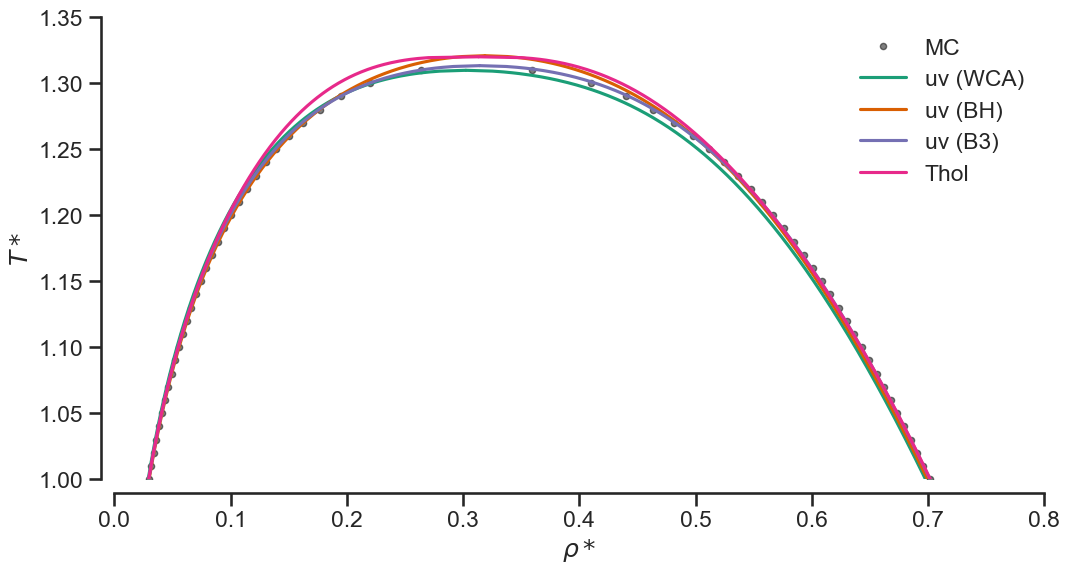

In [24]:
s3 = NAV * sigma_a**3 # factor to calculate dimensionless density 
colors = sns.color_palette("Dark2", n_colors = 6)
plt.figure(figsize=(12, 6))

plt.plot(nist_data.rhov, nist_data.t, linestyle="", color="k", marker=".", label='MC', alpha=0.5)
plt.plot(nist_data.rhol, nist_data.t, linestyle="", color="k", marker=".", alpha=0.5)

plt.plot(vle_uv.vapor.density * s3 , vle_uv.vapor.temperature / eps_k_k, color=colors[0], label='uv (WCA)')
plt.plot(vle_uv.liquid.density * s3, vle_uv.vapor.temperature / eps_k_k, color=colors[0])

plt.plot(vle_uv_bh.vapor.density * s3 , vle_uv_bh.vapor.temperature / eps_k_k, color=colors[1], label='uv (BH)')
plt.plot(vle_uv_bh.liquid.density * s3, vle_uv_bh.vapor.temperature / eps_k_k, color=colors[1])

plt.plot(vle_uv_b3.vapor.density * s3 , vle_uv_b3.vapor.temperature / eps_k_k, color=colors[2], label='uv (B3)')
plt.plot(vle_uv_b3.liquid.density * s3, vle_uv_b3.vapor.temperature / eps_k_k, color=colors[2])

plt.plot(vle_thol.vapor.density * s3 , vle_thol.vapor.temperature / eps_k_k, color=colors[3], label='Thol')
plt.plot(vle_thol.liquid.density * s3, vle_thol.vapor.temperature / eps_k_k, color=colors[3])

plt.ylabel(r"$T*$")
plt.xlabel(r"$\rho*$")
plt.xlim(0., 0.8)
plt.ylim(1.0, 1.35)
plt.legend(frameon=False)
sns.despine(offset=10);

**Calculate Errors compared to NIST data (MC)**
- dimensionless vapor density $\rho^{v*}$
- dimensionless liquid density $\rho^{l*}$
- dimensionless vapor pressure $p^{v*}$

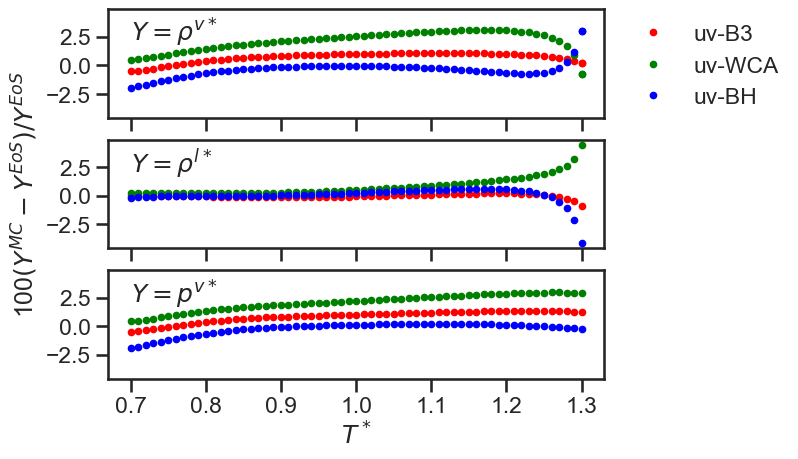

In [25]:

def plot_vle_errors():
    nist_data_subset = nist_data.loc[nist_data['t']< 1.30977] #use only data with temperatures where all EoS are subcritical

    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True)

    for i, row in nist_data_subset.iterrows():
        temp = row['t']
        rhov = row['rhov']
        rhol = row['rhol']
        psat = row['p']

        vle_uvb3  = PhaseEquilibrium.pure(uvtheory_b3, temp * eps_k_k)
        rhov_uvb3 = vle_uvb3.vapor.density * NAV * (sigma * ANGSTROM)**3
        rhol_uvb3 = vle_uvb3.liquid.density * NAV * (sigma * ANGSTROM)**3
        ps_uvb3 = vle_uvb3.vapor.pressure() / (KB * eps_k_k ) * (sigma * ANGSTROM)**3
        err_uvb3_rhov = (rhov - rhov_uvb3) / rhov * 100
        err_uvb3_rhol = (rhol - rhol_uvb3) / rhol * 100
        err_uvb3_ps = (psat - ps_uvb3) / psat * 100

        vle_uvwca  = PhaseEquilibrium.pure(uvtheory_wca, temp * eps_k_k)
        rhov_uvwca = vle_uvwca.vapor.density * NAV * (sigma * ANGSTROM)**3
        rhol_uvwca = vle_uvwca.liquid.density * NAV * (sigma * ANGSTROM)**3
        ps_uvwca = vle_uvwca.vapor.pressure() / (KB * eps_k_k ) * (sigma * ANGSTROM)**3
        err_uvwca_rhov = (rhov - rhov_uvwca) / rhov * 100
        err_uvwca_rhol = (rhol - rhol_uvwca) / rhol * 100
        err_uvwca_ps = (psat - ps_uvwca) / psat * 100


        vle_uvbh  = PhaseEquilibrium.pure(uvtheory_bh, temp * eps_k_k)
        rhov_uvbh = vle_uvbh.vapor.density * NAV * (sigma * ANGSTROM)**3
        rhol_uvbh = vle_uvbh.liquid.density * NAV * (sigma * ANGSTROM)**3
        ps_uvbh = vle_uvbh.vapor.pressure() / (KB * eps_k_k ) * (sigma * ANGSTROM)**3
        err_uvbh_rhov = (rhov - rhov_uvbh) / rhov * 100
        err_uvbh_rhol = (rhol - rhol_uvbh) / rhol * 100
        err_uvbh_ps = (psat - ps_uvbh) / psat * 100


        axs[0].plot(temp, err_uvb3_rhov, 'r.')
        axs[0].plot(temp, err_uvwca_rhov, 'g.')
        axs[0].plot(temp, err_uvbh_rhov,  'b.')

        axs[1].plot(temp, err_uvb3_rhol, 'r.')
        axs[1].plot(temp, err_uvwca_rhol, 'g.')
        axs[1].plot(temp, err_uvbh_rhol,  'b.')
        
        axs[2].plot(temp, err_uvb3_ps, 'r.')
        axs[2].plot(temp, err_uvwca_ps, 'g.')
        axs[2].plot(temp, err_uvbh_ps, 'b.')
        
        
        
        
    axs[0].plot(temp, err_uvb3_rhov, 'r.', label='uv-B3')
    axs[0].plot(temp, err_uvwca_rhov, 'g.', label='uv-WCA')
    axs[0].plot(temp, err_uvbh_rhov, 'b.', label='uv-BH')


    axs[0].text(0.7, 2.1, '$Y=\\rho^{v*}$')
    axs[1].text(0.7, 2, '$Y=\\rho^{l*}$')
    axs[2].text(0.7, 2, '$Y=p^{v*}$')

    axs[0].legend(frameon=False, bbox_to_anchor=(1.01, 1.05))
    axs[1].set_ylabel('100$(Y^{MC}-Y^{EoS}) / Y^{EoS}$')

    plt.xlabel('$T^*$')    
    return

plot_vle_errors()  

## Compare Third Virial Coefficients

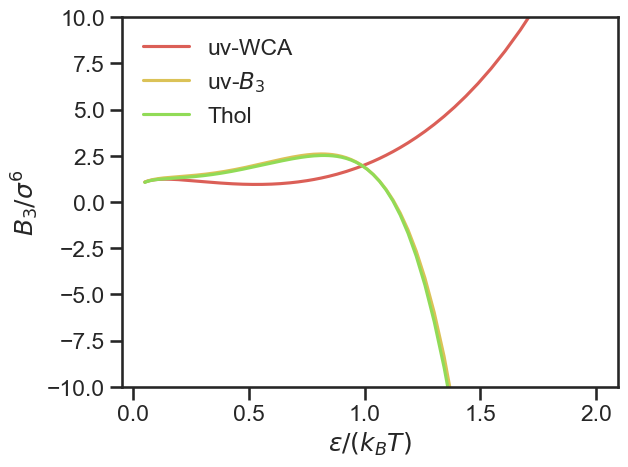

In [26]:
def plot_third_virial_coeff():
    tvec = np.linspace(0.5, 20, 800)
   
    b3_uv_wca  = []
    b3_uv_b3 = []
    b3_thol = []
    for temp in tvec:
        b3_uv_wca.append(uvtheory_wca.third_virial_coefficient(temp * eps_k_k) / (sigma * ANGSTROM)**6 / NAV**2)
        b3_uv_b3.append(uvtheory_b3.third_virial_coefficient(temp * eps_k_k) / (sigma * ANGSTROM)**6 / NAV**2)
        b3_thol.append(thol.third_virial_coefficient(temp * eps_k_k) / (sigma * ANGSTROM)**6 / NAV**2)

    plt.plot(1/tvec, b3_uv_wca, '-', label='uv-WCA')
    plt.plot(1/tvec, b3_uv_b3, label='uv-$B_3$')
    plt.plot(1/tvec, b3_thol, '-', label='Thol')
    plt.ylim(-10, 10)
    plt.ylabel('$B_3 / \\sigma^6$')
    plt.xlabel('$\\varepsilon/(k_BT)$')
    plt.legend(frameon=False)
    return
plot_third_virial_coeff()

## Compare isochoric heat capacity isotherms

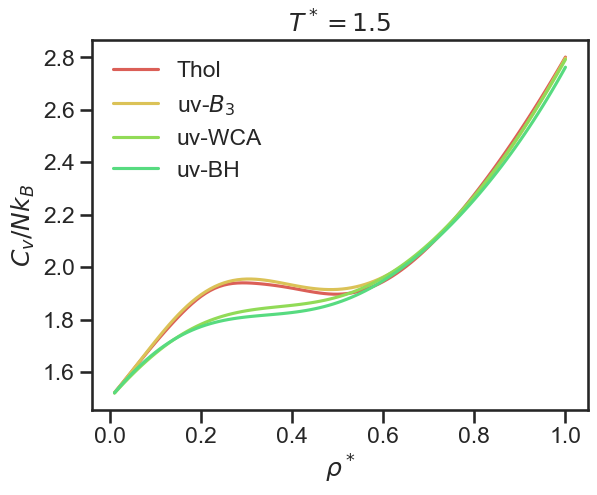

In [28]:
def plot_heat_capcities(temp):
    dimensionless_density = np.linspace(0.01, 1.0, 100)
    cv_thol = []
    cv_uv_b3 = []
    cv_uv_wca = []
    cv_uv_bh = []
    for rho in dimensionless_density:
        density = rho / (sigma * ANGSTROM)**3 / NAV
        temperature = temp * eps_k_k
        s_thol = State(thol, density = density, temperature = temperature)
        cv_thol.append(s_thol.molar_isochoric_heat_capacity(Contributions.Residual) / (RGAS) + 3.0 / 2.0)
        s_uv_b3 = State(uvtheory_b3, density = density, temperature = temperature)
        cv_uv_b3.append(s_uv_b3.molar_isochoric_heat_capacity(Contributions.Residual) / (RGAS) + 3.0 / 2.0)
        s_uv_wca = State(uvtheory_wca, density = density, temperature = temperature)
        cv_uv_wca.append(s_uv_wca.molar_isochoric_heat_capacity(Contributions.Residual) / (RGAS) + 3.0 / 2.0)
        s_uv_bh = State(uvtheory_bh, density = density, temperature = temperature)
        cv_uv_bh.append(s_uv_bh.molar_isochoric_heat_capacity(Contributions.Residual) / (RGAS) + 3.0 / 2.0)
        
      
    plt.plot(dimensionless_density, cv_thol, '-', label='Thol')
    plt.plot(dimensionless_density, cv_uv_b3, '-', label='uv-$B_3$')
    plt.plot(dimensionless_density, cv_uv_wca, '-', label='uv-WCA')
    plt.plot(dimensionless_density, cv_uv_bh, '-', label='uv-BH')
   
    plt.xlabel('$\\rho^*$')
    plt.ylabel('$C_v/Nk_B$')
    plt.title('$T^*={}$'.format(temp))
    plt.legend(frameon=False)
    return
plot_heat_capcities(1.5)
    